# Pure Location Estimation Arena

Which method of estimation is the best for our location estimation problem? This notebook arena test them in static sensor, static source setting with different levels of initial guess error, noise level, and sensor formation.

In [11]:

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
from matplotlib.lines import Line2D

from IPython.display import HTML

import pickle as pkl
import networkx as nx
from matplotlib import style
import jax.numpy as jnp
from jax import jacfwd, jit,grad
from functools import partial


from Robot import Robot
from virtual_sensor import virtual_sensor
from utils.DynamicFilters import getDynamicFilter,joint_meas_func, EKF
from utils.FIMPathPlanning import FIM_ascent_path_planning 
from utils.dLdp import FIM,FIM_mix,analytic_dLdp,analytic_dhdz
from utils.regions import CircleExterior
from tracking_log import logger



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
class EKF_wrap(EKF):
    def __init__(self,q0,C1s,C0s,ks,bs):
        super().__init__(q0)
        self.h=partial(joint_meas_func,C1s,C0s,ks,bs)# Freeze the coefficients, the signature becomes h(z,ps)
        self.dhdz=partial(analytic_dhdz,C1s,C0s,ks,bs)
    def update_and_estimate_loc(self,y,ps):
        return super().update_and_estimate_loc(self.h,self.dhdz,y,ps)

In [34]:
def main(sensor_locs,src_locs,q_0,N_iter,FILTER):
    # Set up mobile sensors and sources
    sensor_names = ["mobile_sensor_{}".format(i+1) for i in range(len(sensor_locs))]
    mobile_sensors = [Robot(loc,name) for loc,name in zip(sensor_locs,sensor_names)]
      
    src_names = ["source_{}".format(i+1) for i in range(len(src_locs))]
    source = [Robot(loc,name) for loc,name in zip(src_locs,src_names)]

    # Set up virtual sensors
    C1=0
    C0=0
    k=1
    b=-2
    std = 0.1
    vs = virtual_sensor(C1,C0,b,k,std)

    # Set up location estimator
    n_sen = len(mobile_sensors)
    n_src = len(source)

    C1s=C1*np.ones(n_sen)
    C0s = C0*np.ones(n_sen)
    ks = k * np.ones(n_sen)
    bs = b*np.ones(n_sen)  
  
    estimator = FILTER(q_0,C1s,C0s,ks,bs)

    # Set up data logger
    log = logger(sensor_names,src_names)
    log.est_locs_log =dict({'Estimation':[]})
    
    # Assume fixed topology, pre-set the measurement model and waypoint planner(expensive to be created in the main loop)
    ps = np.array([r.loc for r in mobile_sensors])
    qs = np.array([s.loc for s in source])
      
   
    # Enter main loop
    Ks = []
    Cs = []
    Ps = []
    ys = []
    yhats = []

    for _ in range(N_iter):
        log.est_locs_log["Estimation"].append(estimator.qhat)
        
        # Measure
        ps = np.array([r.loc for r in mobile_sensors])
        qs = np.array([s.loc for s in source])
          
        y = vs.measurement(qs,ps)
          # Record
        for s in source:
            log.src_locs[s.name].append(s.loc)

        # Estimate.
        estimator.update_and_estimate_loc(y,ps)
       
        yhats.append(estimator._yhat)

    out=log.export()
    
    return out




In [83]:
def plot_result(qhats,src_locs,sensor_locs):

    # Plot sensor, src locations, and qhats.
    qmean = np.mean(qhats,axis=0)
    qstd = np.std(qhats,axis=0)
    
    fig = plt.figure(dpi=100)

    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 1])
    ax3 = fig.add_subplot(gs[:,0])
    
    ax = ax3
    ax.scatter(src_locs[:,0],src_locs[:,1],marker='*',s=50,label='Source')
    ax.scatter(sensor_locs[:,0],sensor_locs[:,1],marker='.',s=50,label='Sensors')
    ax.scatter(qmean[0,0],qmean[0,1],marker='*',s=50,label='Initial Guess',facecolor="None",edgecolor='r')

    ax.axis('on')
    ax.axis('equal')
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_xlim((-10,20))
    ax.set_ylim((-10,20))
    ax.legend()
    
    # Plot qhat in time

#     fig.suptitle('Estimation vs Time.')
    ax=[ax1,ax2]
    for _ in range(2):
        if _<2:
            ax[_].plot(range(len(qmean)),src_locs[:,_]*np.ones(len(qmean)),'-.')
            custom_lines = [Line2D([0], [0], color='blue', ls='-.'),]
            ax[_].legend(custom_lines, ['True $q_{}$'.format(_)])
            
            y=qmean[:,_]
            error = qstd[:,_]
            x = range(len(y))
            ax[_].plot(y)
            ax[_].fill_between(x, y-error, y+error,alpha=0.5)
            ax[_].set_ylabel(r'$\hat q_{}$'.format(_))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()



In [100]:
def test(Filter):
    src_locs = np.array([[8.,8.]])
    # sensor_center = src_locs
    # r=0.5
    # thetas = np.pi * 2 * np.linspace(0.5,0.75,3)
    # sensor_locs =  r*np.vstack([np.sin(thetas),np.cos(thetas)]).T+sensor_center

    N_iter =100
    qhats = []
    sens_locs = []

    r=[0.5,3,5]
    # Simulating
    initial_guesses = np.array([[0,0],[4,4],[7,7]])

    for r in r:
        thetas = np.pi * 2 * np.linspace(0,1,3,endpoint=False)
        sensor_locs = r*np.vstack([np.sin(thetas),np.cos(thetas)]).T+np.array([[8.,8]])


        for i in range(len(initial_guesses)):
            q_0 = initial_guesses[i,:]

            qh = []
            rep = 100
            for _ in range(rep):
                record = main(sensor_locs,src_locs,q_0,N_iter,FILTER=Filter)
                qh.append(record['est_locs_log']['Estimation'])
            qhats.append(qh)
            sens_locs.append(sensor_locs)


    for i,(qhat,sensor_locs) in enumerate(zip(qhats,sens_locs)):
    #     print('-----------------------------------------------')
    #     print('Initial guess: {}'.format(initial_guesses[i,:]))
        plot_result(qhat,src_locs,sensor_locs)


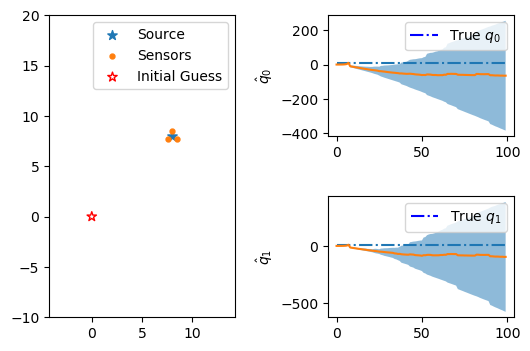

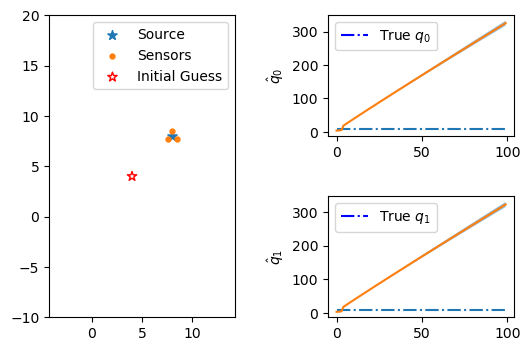

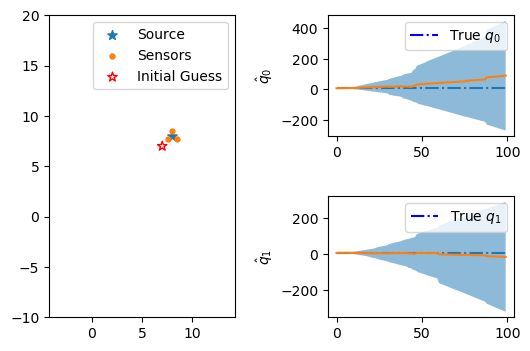

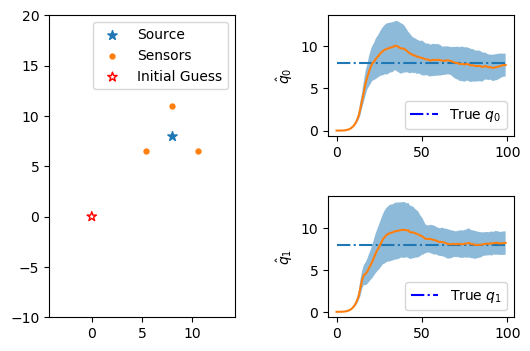

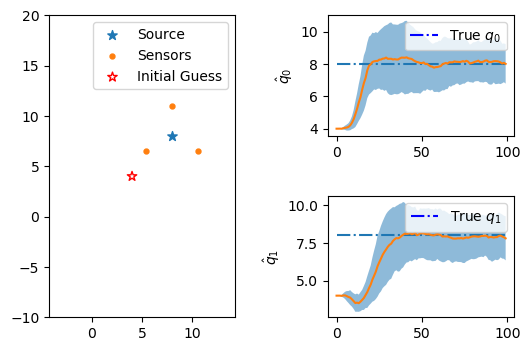

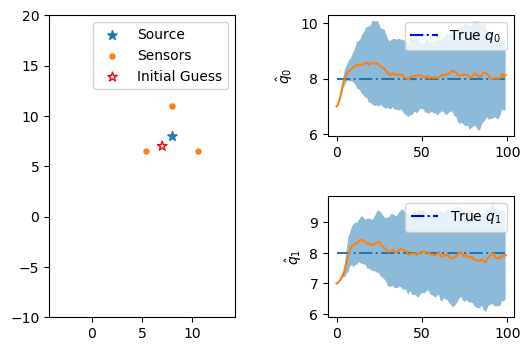

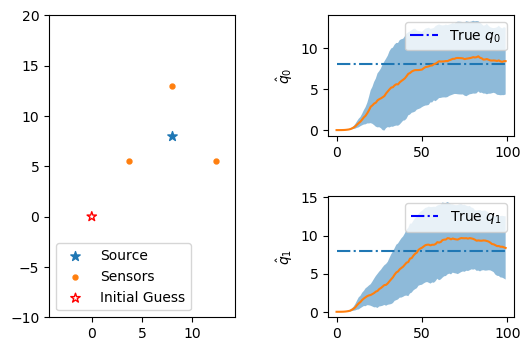

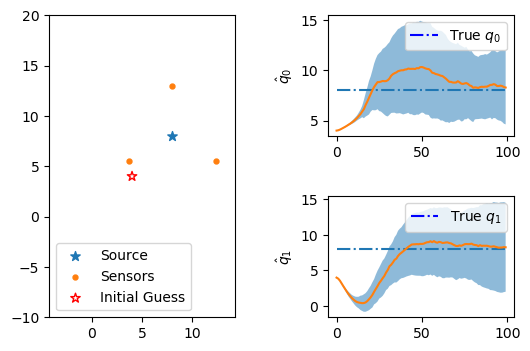

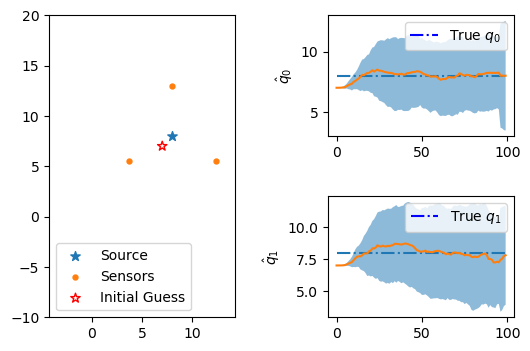

In [101]:
test(EKF_wrap)

## To test list

* Multi-lateration
* Trust Region min-square error
* Particle Filter
* Unscented Kalman Filter

In [ ]:
from utils.RemotePCCodebase import multi_lateration
class MultiLat_wrap:
    def __init__(self,q0,C1s,C0s,ks,bs):
        self.C1s=C1s
        self.C0s=C0s
        self.ks=ks
        self.bs=bs
    def update_and_estimate_loc(self,y,ps):
        return multi_lateration(ps,y,self.C1s,self.C0,self.,b=-2.16)